<a href="https://colab.research.google.com/github/AdamAnderB/AOW_practice/blob/main/Working_HDDM_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate

!pip install pymc #==5.6.0
!pip install ssm-simulators #==0.3.1
!pip install huggingface-hub #>=0.16.4
!pip install blackjax
!pip install graphviz

!pip install numpy==1.25.4 #was 1.24.4
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro

created virtual environment CPython3.10.12.final.0-64 in 388ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.

In [3]:
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Basics
import os
import sys
import time
import jax

from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config

jax.config.update("jax_enable_x64", False)

!pip install --upgrade --force-reinstall scipy

<ipython-input-3-469d3a9ef623>:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.
hssm 0.

In [4]:
# Specify parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]


# Simulate data
sim_out = simulator.simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=500,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,0.807509,-1.0
1,5.094437,1.0
2,4.116862,1.0
3,2.136596,1.0
4,1.870078,1.0
...,...,...
495,3.213341,1.0
496,0.663187,1.0
497,2.056430,1.0
498,1.115644,1.0


In [6]:
from google.colab import files

uploaded = files.upload()


Saving sp_24_HDDM_music_data.csv to sp_24_HDDM_music_data (4).csv


In [7]:
file_name = list(uploaded.keys())[0]
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,Participant.Private.ID,Trial.Number,Spreadsheet.Name,Reaction.Time,rt_correct,Answer_correct,melody_score,beat_score,centered_beats,centered_melody
0,1,9353724,1,Mandarin,318.0,318.0,1,1.0,0.966667,0.649675,0.655506
1,2,9353724,2,Mandarin,369.0,369.0,1,1.0,0.966667,0.649675,0.655506
2,3,9353724,3,Mandarin,339.0,339.0,1,1.0,0.966667,0.649675,0.655506
3,4,9353724,4,Mandarin,609.0,609.0,1,1.0,0.966667,0.649675,0.655506
4,5,9353724,5,Mandarin,450.0,450.0,1,1.0,0.966667,0.649675,0.655506


In [9]:
#adduseful columns
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df = df[df['Spreadsheet.Name'] == 'Mandarin']

# Display the updated DataFrame
df['response'] = df['response'].replace({0: -1})
df1 = df[['rt', 'response']]



summary = df1.describe()
print(summary)
df1.head()
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Display the DataFrame
#df1


                rt     response
count  3433.000000  3433.000000
mean    374.077308     0.847364
std     225.769678     0.531090
min       1.000000    -1.000000
25%     215.800000     1.000000
50%     319.300000     1.000000
75%     495.000000     1.000000
max    1081.500000     1.000000


<ipython-input-9-975624d2b2f2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = df['response'].replace({0: -1})


,rt,response
0,318.0,1
1,369.0,1
2,339.0,1
3,609.0,1
4,450.0,1


In [10]:
simple_ddm_model = hssm.HSSM(data=df1)

In [11]:
print(simple_ddm_model)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3433

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


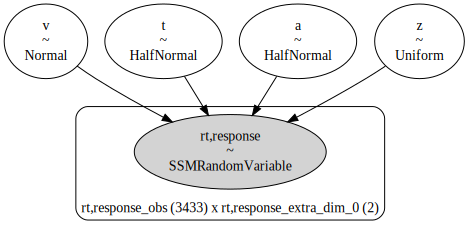

In [12]:
simple_ddm_model.graph()

In [13]:
#pip install --upgrade --force-reinstall scipy

In [14]:
infer_data_simple_ddm_model = simple_ddm_model.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [15]:
type(infer_data_simple_ddm_model)

arviz.data.inference_data.InferenceData

In [16]:
infer_data_simple_ddm_model

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [17]:
az.summary(infer_data_simple_ddm_model)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.051,0.001,0.049,0.053,0.000,0.000,698.0,724.0,1.00
t,0.050,0.048,0.000,0.141,0.002,0.001,414.0,243.0,1.01
a,22.710,0.196,22.353,23.068,0.009,0.006,531.0,701.0,1.01
z,0.503,0.006,0.491,0.515,0.000,0.000,387.0,468.0,1.01


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


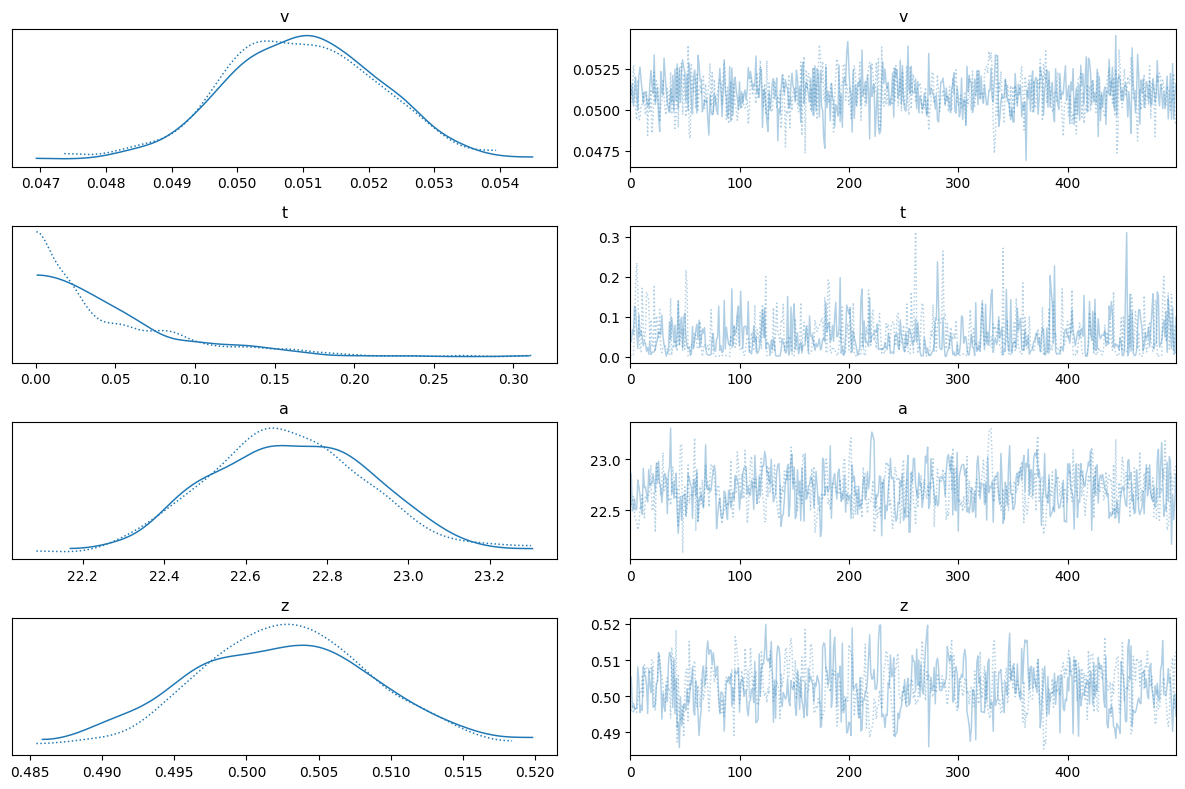

In [18]:
az.plot_trace(
    infer_data_simple_ddm_model,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

In [19]:
constant_values = np.all(df1 == df1.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df1.isnull().any()
print(nan_values)

rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

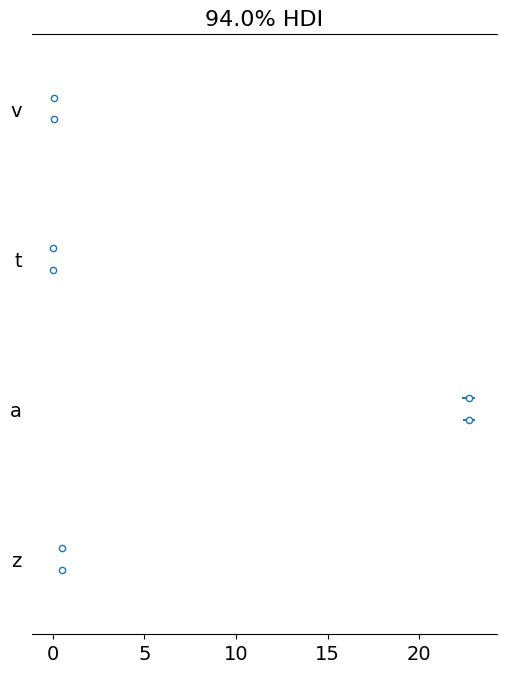

In [20]:
az.plot_forest(simple_ddm_model.traces)

array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 't'}>,
       <Axes: title={'center': 'a'}>, <Axes: title={'center': 'z'}>],
      dtype=object)

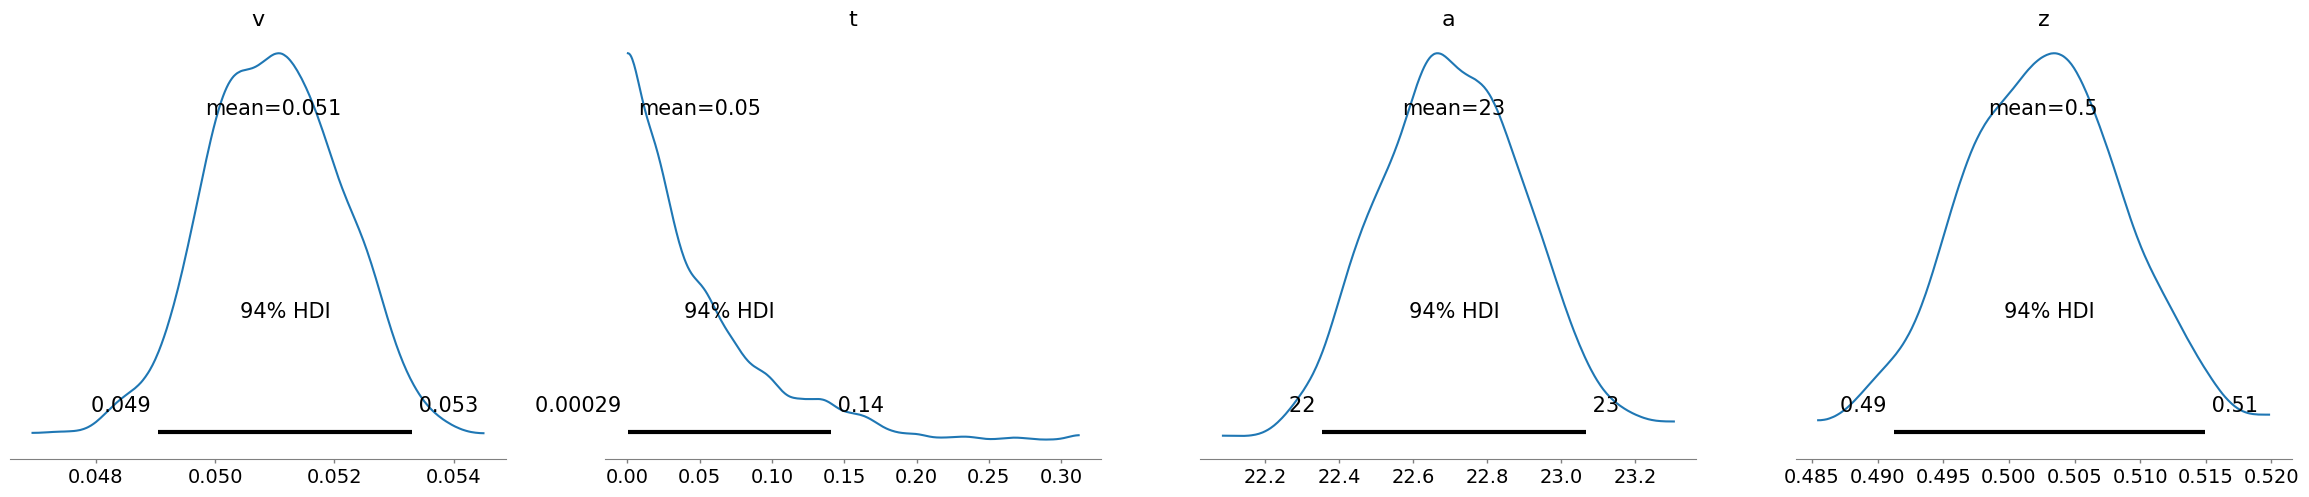

In [21]:
az.plot_posterior(simple_ddm_model.traces)

array([[<Axes: ylabel='t'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v', ylabel='z'>, <Axes: xlabel='t'>,
        <Axes: xlabel='a'>]], dtype=object)

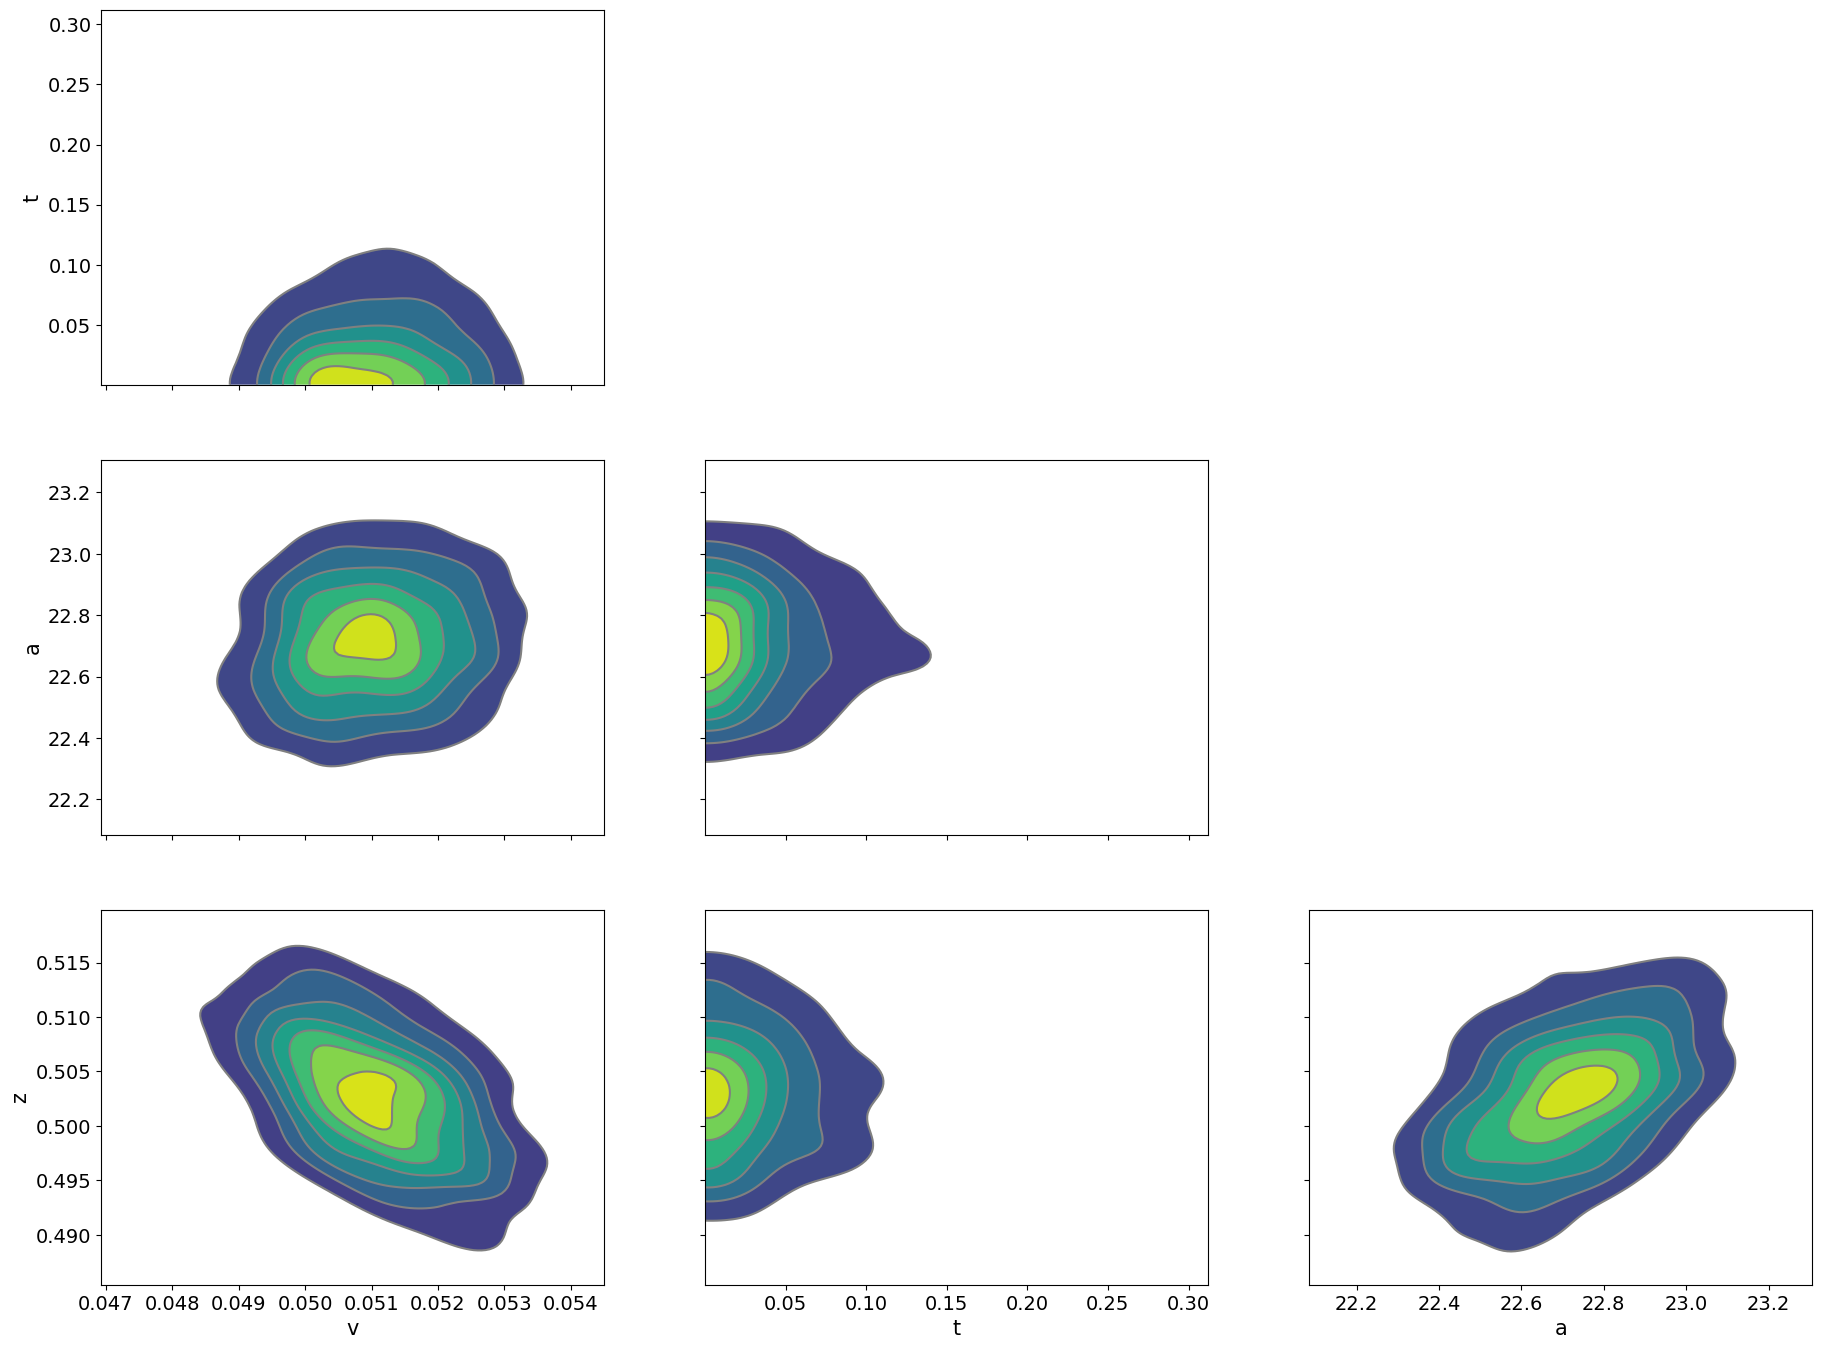

In [22]:
az.plot_pair(simple_ddm_model.traces, kind="kde")

In [23]:
simple_ddm_model.loglik_kind

'analytical'

complex model

In [ ]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x + y",
            "link": "identity",
        }
    ],
)